# Xopt Evaluator Basic Usage 

In [1]:
# needed for macos
import platform
if platform.system() == 'Darwin':
    import multiprocessing as mp                                                                                     
    mp.set_start_method("fork")    


In [2]:
from xopt import XoptBase, Evaluator, Generator, VOCS
from xopt.generators.random import RandomGenerator
from xopt.generators.bayesian import UpperConfidenceBoundGenerator
from xopt.evaluator import DummyExecutor
import numpy as np
import pandas as pd
from time import sleep
from random import randint

In [3]:

vocs = VOCS(variables = {'x': [0,1], 'y': [0,1]}, objectives = {'f1':'MINIMIZE'})

def f(inputs):

    sleep(randint(1, 5)) # simulate computation time
    # Make some occasional errors
    if inputs['x'] > 0.8:
        raise ValueError('x > 0.8')

    return {'f1': inputs['x']**2 + inputs['y']**2}

in1 = vocs.random_inputs()
f(in1)

{'f1': 0.6372410863177095}

In [4]:
X = XoptBase(generator=RandomGenerator(vocs), 
    evaluator=Evaluator(f), 
    vocs=vocs)

# Submit to the evaluator some new inputs
X.submit_data(vocs.random_inputs(4))

# Unevaluated inputs are collected in a dataframe
X._input_data

,x,y
0,0.438340,0.398750
1,0.459351,0.333826
2,0.582964,0.782742
3,0.001707,0.776328


In [5]:
# Internal futures dictionary
X._futures

{0: <Future at 0x105b42940 state=finished returned dict>,
 1: <Future at 0x105b42e80 state=finished returned dict>,
 2: <Future at 0x11e766040 state=finished returned dict>,
 3: <Future at 0x105aa17c0 state=finished returned dict>}

In [6]:
# Collect all finished futures and updata dataframe
X.update_data()
X.data

,x,y,f1,xopt_error,xopt_error_str
0,0.438340,0.398750,0.351144,False,
1,0.459351,0.333826,0.322443,False,
2,0.582964,0.782742,0.952532,False,
3,0.001707,0.776328,0.602688,False,


In [7]:
# Futures are now cleared out
X._futures

{}

In [8]:
# This is the internal counter
X._ix_last

3

In [9]:
X.submit_data(vocs.random_inputs(4))
X._input_data 

,x,y
4,0.397088,0.991313
5,0.742241,0.738172
6,0.199416,0.466685
7,0.863792,0.139965


In [10]:
X._futures

{4: <Future at 0x1493dfc40 state=finished returned dict>,
 5: <Future at 0x11e766190 state=finished returned dict>,
 6: <Future at 0x11e766400 state=finished returned dict>,
 7: <Future at 0x1493a1eb0 state=finished raised ValueError>}

In [11]:
# Singe generation step
X.step()
X.update_data()
X.data

,x,y,f1,xopt_error,xopt_error_str
0,0.438340,0.398750,0.351144,False,
1,0.459351,0.333826,0.322443,False,
2,0.582964,0.782742,0.952532,False,
3,0.001707,0.776328,0.602688,False,
4,0.397088,0.991313,1.140380,False,
5,0.742241,0.738172,1.095819,False,
6,0.199416,0.466685,0.257562,False,
7,0.863792,0.139965,NaN,True,"Traceback (most recent call last):\n File ""/U..."
8,0.594599,0.471095,0.575479,False,


# Executors

In [12]:
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor


In [13]:
MAX_WORKERS =10

In [14]:
# Dask
# from dask.distributed import Client
# import logging
#client = Client( silence_logs=logging.ERROR)
#executor = client.get_executor()
#client

In [15]:
executor = ThreadPoolExecutor(max_workers=MAX_WORKERS)
#executor = ProcessPoolExecutor(max_workers=MAX_WORKERS)
executor

In [16]:
X2 = XoptBase(
        generator=RandomGenerator(vocs),
        evaluator=Evaluator(f, executor=executor, max_workers=MAX_WORKERS), 
    vocs=vocs,
    asynch=True)

In [17]:
for _ in range(20):
    X2.step()
    X2.update_data()


<AxesSubplot:xlabel='x', ylabel='y'>

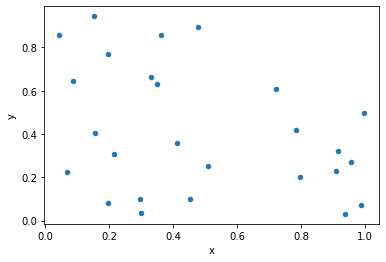

In [18]:
X2.data.plot.scatter('x', 'y')